In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import os
import json

def filter_skip_relations(all_relations, allowed_relations):
    """Return a list of relations not in allowed_relations."""
    return [r for r in all_relations if r not in allowed_relations]


def transform_data_to_llm_format(data, preprompt="", start_idx=0, skip_relations=[], max_turns=10, max_speakers=2):
    """Transform the given data into LLM ready dialogue format."""
    new_data = []
    identity_counter = start_idx

    for conversation, triples in data:
        # Filtering dialogues based on max_turns criteria
        if max_turns is not None and len(conversation) > max_turns:
            continue

        # Extracting speaker names from each dialogue turn and checking based on max_speakers criteria
        if max_speakers is not None:
            speakers = set([turn.split(":")[0].strip() for turn in conversation])
            if len(speakers) > max_speakers:
                continue


        triples_text = [
            {
                "x": triple["x"],
                "x_type": triple["x_type"],
                "r": triple["r"][0].split(':')[-1],
                "y": triple["y"],
                "y_type": triple["y_type"]
            }
            for triple in triples
            if triple["r"] and triple["r"][0].split(':')[-1] not in skip_relations
        ]

        conversation_entry = {
            "id": f"identity_{identity_counter}",
            "conversations": [
                {"from": "human", #tried: human
                 "value": preprompt + "\n".join(conversation)},
                {"from": "gpt", #tried: gpt
                 "value": str(json.dumps(triples_text))}
            ]
        }

        identity_counter += 1

        if triples_text:
            new_data.append(conversation_entry)

    return new_data


def create_directory_if_not_exists(directory_path):
    """Create a directory if it does not already exist."""
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)


def process_and_save_data(file_sets, input_dir, output_dir, skip_relations, preprompt="", total_relation_count=35, max_turns=10, max_speakers=2):
    """Process the input data and save in the specified format."""
    output_data = []
    for files in file_sets:
        data_folder_name = output_dir.split('/')[-1]
        dataset_name = f"{data_folder_name}-{total_relation_count-len(skip_relations)}cls-{'-'.join(files)}"
        last_data_idx = 0
        new_format = []

        create_directory_if_not_exists(output_dir)

        for f in files:
            input_data_path = os.path.join(input_dir, f'{f}.json')
            
            # Check if file exists
            if os.path.exists(input_data_path):
                with open(input_data_path, encoding='utf8') as fp:
                    data = json.load(fp)

                new_format.extend(transform_data_to_llm_format(
                    data, preprompt=preprompt, start_idx=last_data_idx,
                    skip_relations=skip_relations, max_turns=max_turns, max_speakers=max_speakers))
                last_data_idx = len(new_format)

        output_data_path = os.path.join(output_dir, f'{dataset_name}.json')
        with open(output_data_path, 'w', encoding='utf8') as fp:
            json.dump(new_format, fp)

        print(files, len(new_format))
        
        output_data.append(new_format)
        
    return output_data
        
add_one_shot = False
one_shot = """
Input:
[
"User: My daughter, Emma, recently moved to London.",
"Agent: That's exciting! Does she like it there?",
"User: Yes, she loves it! She even adopted a cat named Whiskers.",
]

Output:
[
{{"x": "User", "x_type": "PERSON", "y": "Emma", "y_type": "PERSON", "r": "children"}},
{{"x": "Emma", "x_type": "PERSON", "y": "London", "y_type": "GPE", "r": "place_of_residence"}},
{{"x": "London", "x_type": "GPE", "y": "Emma", "y_type": "PERSON", "r": "residents_of_place"}},
{{"x": "Emma", "x_type": "PERSON", "y": "Whiskers", "y_type": "ANIMAL", "r": "pet"}},
{{"x": "Whiskers", "x_type": "ANIMAL", "y": "Emma", "y_type": "PERSON", "r": "pet"}},
]
"""

all_relations = {
"positive_impression", "negative_impression", "acquaintance", 
"alumni", "boss", "subordinate", "client", "dates", "friends", 
"girl/boyfriend", "neighbor", "roommate", "children", "other_family", 
"parents", "siblings", "spouse", "place_of_residence", "visited_place", 
"origin", "employee_or_member_of", "schools_attended", "works", "age", 
"date_of_birth", "major", "place_of_work", "title", "alternate_names", 
"pet", "residents_of_place", "visitors_of_place", "employees_or_members", 
"students", "unanswerable"
}
allowed_relations = {"acquaintance", "children", "other_family", "parents", 
                    "siblings", "spouse", "place_of_residence", "visited_place", 
                    "pet", "residents_of_place", "visitors_of_place"}

# allowed_relations = all_relations  # uncomment to allow all relations!

preprompt = f"""
Extract personal relevant entities, and their relations. Return only the jsonl format list .

Ontology: 
- relations: {str(allowed_relations).replace("'", '"')}
- types: {{"ORG", "GPE", "PERSON", "DATE", "EVENT", “ANIMAL”}}
{one_shot if add_one_shot else ""}
Input:
"""


def get_output_folder_name(ds_root, skip_relations, max_turns=10, max_speakers=2):
    """Generate a concise and descriptive output folder name."""
    parts = [ds_root, f"{len(all_relations) - len(skip_relations)}cls"]
    
    if max_turns:
        parts.append(f"{max_turns}trn")
    
    if max_speakers:
        parts.append(f"{max_speakers}spkr")
    
    return "-".join(parts)

skip_relations = filter_skip_relations(all_relations, allowed_relations)

# Directories
ds_type = ""
# ds_type = "-typed-pp"
max_turns=10
max_speakers=2
ds_root = f"dialog-re-llama{ds_type}"
INPUT_DIR = "/home/murilo/RelNetCare/data/raw/dialog-re"
OUTPUT_DIR = os.path.join("/home/murilo/RelNetCare/data/processed", get_output_folder_name(
    ds_root=ds_root, skip_relations=skip_relations, max_turns=max_turns, max_speakers=max_speakers))

FILE_SETS = [['train', 'dev'], ['test']]

print(preprompt)

data = process_and_save_data(FILE_SETS, INPUT_DIR, OUTPUT_DIR, skip_relations, preprompt, max_turns=max_turns, max_speakers=max_speakers)


Extract personal relevant entities, and their relations. Return only the jsonl format list .

Ontology: 
- relations: {"other_family", "visitors_of_place", "visited_place", "parents", "place_of_residence", "pet", "residents_of_place", "acquaintance", "siblings", "children", "spouse"}
- types: {"ORG", "GPE", "PERSON", "DATE", "EVENT", “ANIMAL”}

Input:

['train', 'dev'] 62
['test'] 16


In [15]:
data

[[{'id': 'identity_1',
   'conversations': [{'from': 'human',
     'value': '\nExtract personal relevant entities, and their relations. Return only the jsonl format list .\n\nOntology: \n- relations: {"other_family", "visitors_of_place", "visited_place", "parents", "place_of_residence", "pet", "residents_of_place", "acquaintance", "siblings", "children", "spouse"}\n- types: {"ORG", "GPE", "PERSON", "DATE", "EVENT", “ANIMAL”}\n\nInput:\nSpeaker 1: Hey Pheebs.\nSpeaker 2: Hey!\nSpeaker 1: Any sign of your brother?\nSpeaker 2: No, but he\'s always late.\nSpeaker 1: I thought you only met him once?\nSpeaker 2: Yeah, I did. I think it sounds y\'know big sistery, y\'know, \'Frank\'s always late.\'\nSpeaker 1: Well relax, he\'ll be here.'},
    {'from': 'gpt',
     'value': '[{"x": "Speaker 2", "x_type": "PER", "r": "siblings", "y": "Frank", "y_type": "PER"}, {"x": "Frank", "x_type": "PER", "r": "siblings", "y": "Speaker 2", "y_type": "PER"}]'}]},
  {'id': 'identity_2',
   'conversations': [{

In [5]:
from tqdm import tqdm
import openai
import json
from collections import defaultdict, OrderedDict

# Initialize OpenAI
openai.api_key = "EMPTY"
openai.api_base = "http://localhost:8000/v1"
model = "vicuna-7b-v1.1"

def infer_from_model(dialogue, preprompt=""
                    #  "A system that extracts entities and their relations from dialogues. It returns results in jsonl format. Input text: "
                     ):
    """Perform model inference given a prompt."""
    completion = openai.ChatCompletion.create(
        model=model,
        messages=[{
            "role": "user",
            "content": preprompt + dialogue
        }]
    )
    return completion.choices[0].message.content


def calculate_metrics_for_entry(true_labels, predicted_labels):
    if not true_labels and not predicted_labels:  # If both are empty
        return 1, 1, 1

    if not true_labels or not predicted_labels:  # If one of them is empty
        return 0, 0, 0

    true_set = set(true_labels)
    predicted_set = set(predicted_labels)

    tp = len(true_set & predicted_set)
    fp = len(predicted_set - true_set)
    fn = len(true_set - predicted_set)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

def assess_performance_on_test_dataset(test_file_path, cap_size=None, return_details=False):
    with open(test_file_path, 'r', encoding='utf8') as fp:
        test_data = json.load(fp)
    
    if cap_size:
        test_data = test_data[:cap_size]

    details = []
    results_per_class = defaultdict(list)
    pbar = tqdm(test_data, desc="Processing", dynamic_ncols=True, leave=False)

    overall_predictions = []
    overall_true = []

    for entry in pbar:
        prompt = "\n".join([message["value"] for message in entry["conversations"] if message["from"] == "human"])
        try:
            predicted_relations = json.loads(infer_from_model(prompt), object_pairs_hook=OrderedDict)
            true_relations = json.loads(entry["conversations"][1]["value"], object_pairs_hook=OrderedDict)

            predicted_labels = [str(pred_relation) for pred_relation in predicted_relations]
            true_labels = [str(true_relation) for true_relation in true_relations]

            for true_relation in true_relations:
                results_per_class[true_relation.get('r')].append((predicted_labels, true_labels))

            precision, recall, f1 = calculate_metrics_for_entry(true_labels, predicted_labels)
            
            overall_predictions.extend(predicted_labels)
            overall_true.extend(true_labels)

            pbar.set_description(f"P: {precision:.2f} | R: {recall:.2f} | F1: {f1:.2f}")

            if return_details:
                details.append({
                    "id": entry['id'],
                    "prompt": prompt,
                    "predicted_relations": predicted_relations,
                    "true_relations": true_relations,
                    "precision": precision,
                    "recall": recall,
                    "f1": f1 
                })

        except Exception as e:
            tqdm.write(f"Error processing entry with id {entry['id']}: {e}")

    overall_precision, overall_recall, overall_f1 = calculate_metrics_for_entry(overall_true, overall_predictions)

    per_class_results = {}
    for relation, labels_list in results_per_class.items():
        preds, trues = [], []
        for preds_labels, true_labels in labels_list:
            preds.extend(preds_labels)
            trues.extend(true_labels)
        
        precision, recall, f1 = calculate_metrics_for_entry(trues, preds)
        
        per_class_results[relation] = {
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

    result = {
        "overall": {
            "precision": overall_precision,
            "recall": overall_recall,
            "f1": overall_f1
        },
        "per_class": per_class_results
    }

    if return_details:
        result["details"] = details

    return result

# Example Usage:
test_file_path = f"/home/murilo/RelNetCare/data/processed/dialog-re-llama-{ds_type}/dialog-re-llama-{ds_type}-11cls-test.json"  # Or whatever the exact path is.
# results = assess_performance_on_test_dataset(test_file_path, cap_size=None, return_details=True)
# results['overall']

In [27]:
# infer_from_model('Alice: Hi, you are my father.\nRobert: Yes, I am your father', preprompt=preprompt)
infer_from_model('Alice: I went to Maryland.\nRobert: Why?\nAlice: I work at Google there.', preprompt=preprompt)

'[{"x": "Alice", "x_type": "PER", "r": "place_of_residence", "y": "Maryland", "y_type": "GPE"}, {"x": "Maryland", "x_type": "GPE", "r": "residents_of_place", "y": "Alice", "y_type": "PER"}]'

In [14]:
import pandas as pd
df = pd.DataFrame(results['details'])
print(json.dumps(df.sort_values('f1').iloc[0].to_dict(), indent=4))
# df.sort_values('f1').iloc[0].to_dict()

{
    "id": "identity_195",
    "prompt": "\nExtract personal relevant entities, and their relations. Return only the jsonl format list .\n\nOntology: \n- relations: {\"place_of_residence\", \"visited_place\", \"children\", \"acquaintance\", \"spouse\", \"other_family\", \"pet\", \"siblings\", \"visitors_of_place\", \"residents_of_place\", \"parents\"}\n- types: {\"ORG\", \"GPE\", \"PERSON\", \"DATE\", \"EVENT\", \u201cANIMAL\u201d}\n\nInput:\nSpeaker 1: Hello?\nSpeaker 2: Hey! I just spoke to your dad, and you know what? He seems to think we\u2019ll be able to find a new place for the wedding.\nSpeaker 1: We don\u2019t have to.\nSpeaker 2: Whoa-whoa-what? You found a place?\nSpeaker 1: No. But, Monica and I were talking, and-and I was so upset about the hall being knocked down, and she suggested that we put the wedding off for a bit.\nSpeaker 2: She said what?\nSpeaker 1: She said, \"If I\u2019m not gonna be happy getting married somewhere that we find in a day, well then we should ju

<Axes: >

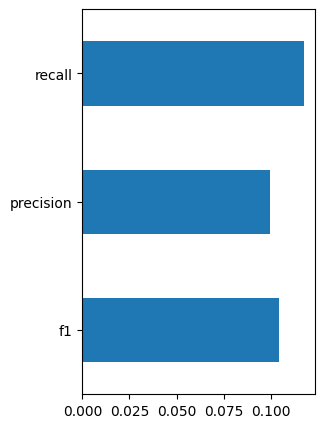

In [15]:
df[['f1', 'precision', 'recall' ]].mean().plot(kind='barh', alpha=1, figsize=(3, 5))


<Axes: ylabel='Frequency'>

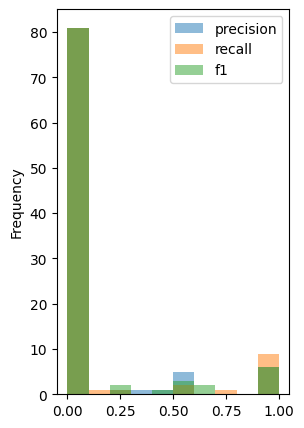

In [13]:
df[['precision', 'recall', 'f1']].plot(kind='hist', alpha=0.5, figsize=(3, 5))


<Axes: >

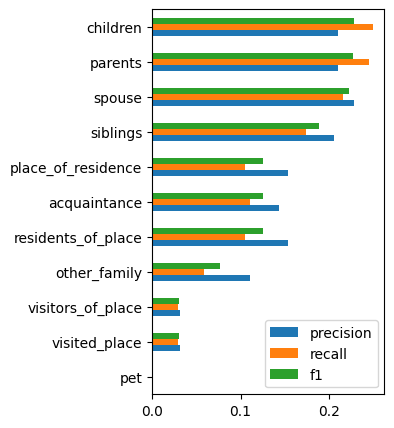

In [28]:
pd.DataFrame(results['per_class']).T.sort_values('f1', ascending=True).plot(kind='barh', figsize=(3, 5))

In [21]:
df['prompt_length'] = df.prompt.apply(len)

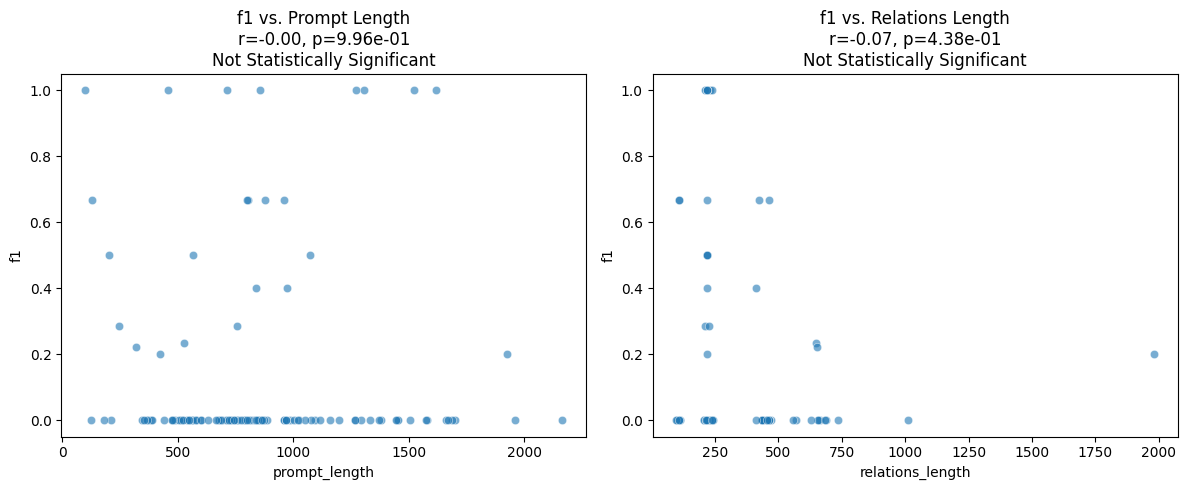

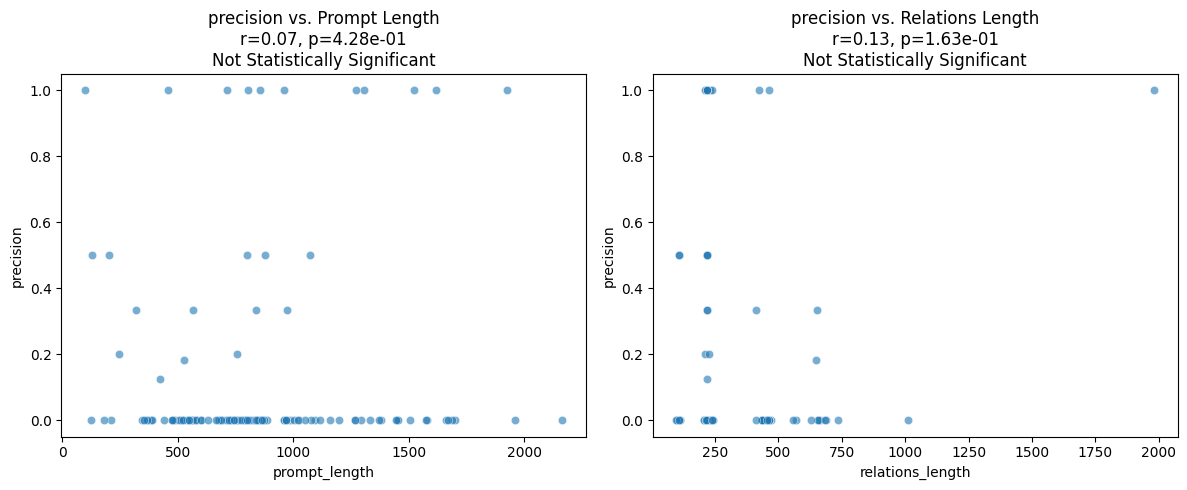

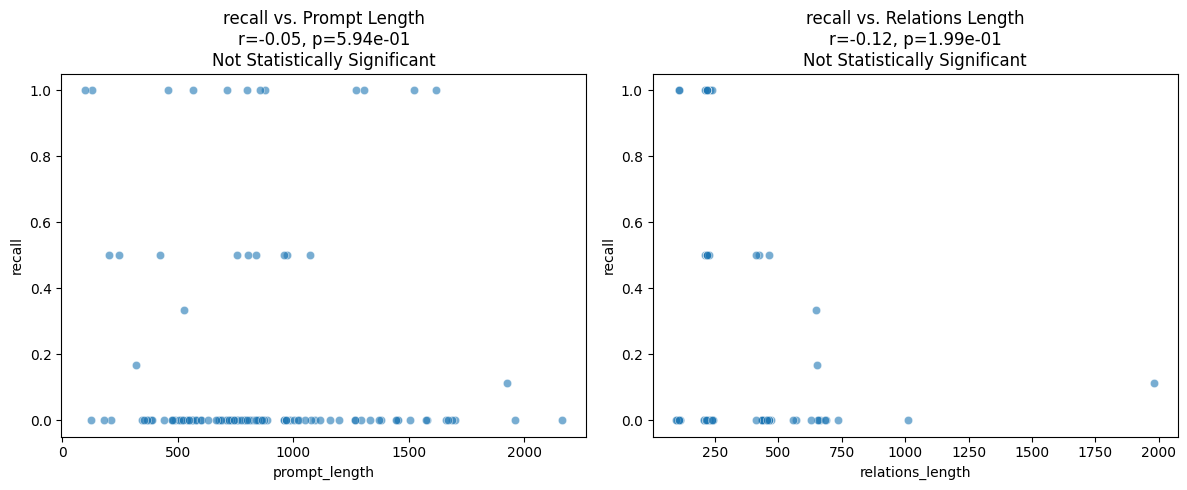

In [22]:
# Compute the metrics correlation with length
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming your dataframe is named df
# Calculate the length of relations for each row
df['relations_length'] = df['true_relations'].apply(lambda x: sum([len(str(relation)) for relation in x]))

# Plotting correlation between prompt length and metrics
metrics = ['f1', 'precision', 'recall']

for metric in metrics:
    plt.figure(figsize=(12, 5))
    
    # Plot for prompt length
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df, x='prompt_length', y=metric, alpha=0.6)
    corr_coef, p_value = pearsonr(df['prompt_length'], df[metric])
    significance = "Statistically Significant" if p_value < 0.05 else "Not Statistically Significant"
    plt.title(f'{metric} vs. Prompt Length\nr={corr_coef:.2f}, p={p_value:.2e}\n{significance}')

    # Plot for relations length
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df, x='relations_length', y=metric, alpha=0.6)
    corr_coef, p_value = pearsonr(df['relations_length'], df[metric])
    significance = "Statistically Significant" if p_value < 0.05 else "Not Statistically Significant"
    plt.title(f'{metric} vs. Relations Length\nr={corr_coef:.2f}, p={p_value:.2e}\n{significance}')

    plt.tight_layout()
    plt.show()


In [23]:
import pandas as pd

# Sort the dataframe by 'f1'
df = df.sort_values('f1')
mask = df.prompt_length < 350
tmp = df[mask]

# Calculate the quartile boundaries
q3 = tmp['f1'].quantile(0.75)

# Select one example from each quartile
example_1 = tmp[df['f1'] <= 0].sample(1)
example_2 = tmp[(df['f1'] > 0) & (df['f1'] <= .45)].sample(1)
example_3 = tmp[(df['f1'] > .25)].sample(1)

# Concatenate the examples to get a dataframe of examples from each quartile
exemplary_samples = pd.concat([example_1, example_2, example_3, example_4])

exemplary_samples


/tmp/ipykernel_203525/2882830022.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  example_1 = tmp[df['f1'] <= 0].sample(1)
/tmp/ipykernel_203525/2882830022.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  example_2 = tmp[(df['f1'] > 0) & (df['f1'] <= .45)].sample(1)
/tmp/ipykernel_203525/2882830022.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  example_3 = tmp[(df['f1'] > .25)].sample(1)


NameError: name 'example_4' is not defined

In [ ]:
def format_relations(relations):
    formatted_relations = []
    for relation in relations:
        try:
            formatted_relations.append({
                "x": relation['x'],
                "x_type": "PERSON",  # Assuming all are persons, you can adjust based on your dataset
                "y": relation['y'],
                "y_type": "PERSON",  # Assuming all are persons, you can adjust based on your dataset
                "r": relation['r']
            })
        except KeyError as e:
            print(f"KeyError: {e}. Problematic relation: {relation}")
    return formatted_relations


def convert_to_new_format(sample, relations='predicted_relations'):
    dialog = []
    
    # Split prompt into sentences and format them
    for line in sample['prompt'].split("\n"):
        speaker, content = line.split(": ", 1)
        dialog.append(f"{speaker}: {content}")
    
    # Format relations
    formatted_relations = format_relations(sample[relations])
    
    return [dialog, formatted_relations]

# Loop through all samples and convert them to the desired format
all_formatted_data = [convert_to_new_format(row.to_dict(), 
                                            # relations='true_relations'
                                            ) for _, row in exemplary_samples.iterrows()]

json.dumps(all_formatted_data)


'[[["Speaker 1: So, thanks for having me over! Rach. Pheebs.", "Speaker 2: See ya!! What the hell was that?!", "Speaker 3: Probably some y\'know, European good-bye thing he picked up in London.", "Speaker 4: That\'s not European!", "Speaker 5: Well, it felt French."], [{"x": "Speaker 1", "x_type": "PERSON", "y": "Pheebs", "y_type": "PERSON", "r": "visitors"}, {"x": "Pheebs", "x_type": "PERSON", "y": "Speaker 1", "y_type": "PERSON", "r": "visitors"}]], [["Speaker 1: Kids, I spoke to a doctor and picked up this pamphlets on how to get pregnant.", "Speaker 2: Hey dad!", "Speaker 3: Hey.", "Speaker 1: Sorry to bother you again, but could you pass my pamphlets back? Thank you."], [{"x": "Speaker 1", "x_type": "PERSON", "y": "Speaker 2", "y_type": "PERSON", "r": "parents"}, {"x": "Speaker 1", "x_type": "PERSON", "y": "Speaker 3", "y_type": "PERSON", "r": "children"}, {"x": "Speaker 3", "x_type": "PERSON", "y": "Speaker 1", "y_type": "PERSON", "r": "parents"}, {"x": "Speaker 2", "x_type": "PE

In [8]:
infer_from_model('Alice: Hi, you are my father.\nRobert: Yes, I am your father', preprompt=preprompt)

'[{"x": "Alice", "x_type": "PER", "r": "parents", "y": "Robert", "y_type": "PER"}, {"x": "Alice", "x_type": "PER", "r": "children", "y": "Robert", "y_type": "PER"}]'

In [ ]:
infer_from_model('Alice: I went to Maryland.\nRobert: Why?\nAlice: I work at Google there.', preprompt=preprompt)

'[{"x": "Alice", "x_type": "PER", "r": "parents", "y": "Robert", "y_type": "PER"}, {"x": "Alice", "x_type": "PER", "r": "children", "y": "Robert", "y_type": "PER"}]'